<a href="https://colab.research.google.com/github/jsalgadop/nn-clasificacion-mlp-cnn/blob/main/Red_neuronal_para_clasificaci%C3%B3n_de_mariposas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim


In [30]:
# Montar el acceso a Google Drive
drive.mount('/content/drive')

# Establecer ruta de acceso a las carpetas del dataset de imágenes
dataset_path = "/content/drive/MyDrive/UTEC/CD & IA/Ciclo III/Machine Learning/Entrenamientos/Clasificación/Redes Neuronales/Análisis de Imágenes/Dataset/"
print(dataset_path)
print("\n")

# Contar cantidad de archivos en cada carpeta
def count_files_in_folder(folder_path):
    return len([i for i in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, i))])

# Mostrar carpeta y cantidad de imágenes que contiene
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        file_count = count_files_in_folder(item_path)
        print(f"{item}: {file_count} imágenes")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UTEC/CD & IA/Ciclo III/Machine Learning/Entrenamientos/Clasificación/Redes Neuronales/Análisis de Imágenes/Dataset/


001. Danaus plexippus: 82 imágenes
002. Heliconius charitonius: 93 imágenes
003. Heliconius erato: 61 imágenes
004. Junonia coenia: 90 imágenes
005. Lycaena phlaeas: 88 imágenes
006. Nymphalis antiopa: 100 imágenes
007. Papilio cresphontes: 89 imágenes
008. Pieris rapae: 55 imágenes
009. Vanessa atalanta: 90 imágenes
010. Vanessa cardui: 84 imágenes


In [27]:
# Definir clase wrapper para aplicar transformaciones después del split
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

# Implementar red neuronal MLP configurable
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation='ReLU', dropout=0.5):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        for hidden in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden))
            if activation == 'ReLU':
                layers.append(nn.ReLU())
            elif activation == 'Tanh':
                layers.append(nn.Tanh())
            elif activation == 'Sigmoid':
                layers.append(nn.Sigmoid())
            layers.append(nn.Dropout(dropout))
            prev_size = hidden
        layers.append(nn.Linear(prev_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

# Implementar función de entrenamiento
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    epoch_times = []
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        print(f'Epoch {epoch+1}/{epochs}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f} | Time {epoch_time:.2f}s')

    avg_epoch_time = np.mean(epoch_times)
    return train_losses, val_losses, train_accs, val_accs, avg_epoch_time

# Implementar función de evaluación
def evaluate_model(model, loader, classes, split_name='Test'):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for inputs, true_labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            labels.extend(true_labels.numpy())
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average=None, zero_division=0)
    rec = recall_score(labels, preds, average=None, zero_division=0)
    f1_per_class = f1_score(labels, preds, average=None, zero_division=0)
    macro_f1 = f1_score(labels, preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    cm = confusion_matrix(labels, preds)

    # Imprimir reporte
    print(f'\n--- {split_name} Evaluation ---')
    print(f'Accuracy: {acc:.4f}')
    print(f'Macro F1: {macro_f1:.4f}')
    print(f'Weighted F1: {weighted_f1:.4f}')
    print('\nPer class metrics:')
    for i, cls in enumerate(classes):
        print(f'{cls}: Precision {prec[i]:.4f}, Recall {rec[i]:.4f}, F1 {f1_per_class[i]:.4f}')
    print('\nConfusion Matrix:')
    print(cm)

    # Mostrar matriz de confusión
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix ({split_name})')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()

    return acc, macro_f1, weighted_f1, cm

# Implementar red neuronal basada en CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_size // 4) ** 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        return x

# Visualizar curvas de análisis
def plot_curves(train_losses, val_losses, train_accs, val_accs, title=''):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f'Loss Curves {title}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.title(f'Accuracy Curves {title}')
    plt.legend()
    plt.show()


In [25]:
# Definir una semilla reproducible para todo el desarrollo
torch.manual_seed(42)
np.random.seed(42)

# Definir tamaño de imagen (pequeño para un MLP eficiente; para un CNN se puede aumentar)
img_size = 64

# Fijar parámetros de normalización estándar
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Ejecutar transformaciones: redimensionar primero, luego aumento ligero solo en train, ToTensor y normalize
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Verificar si la ruta existe y contiene los subdirectorios de cada clase
full_dataset = datasets.ImageFolder(dataset_path)

# Definir clases y número de clases que debería ser 10 según el dataset
classes = full_dataset.classes
num_classes = len(classes)
print(f'Número de clases: {num_classes}')
print(f'Clases: {classes}')


Número de clases: 10
Clases: ['001. Danaus plexippus', '002. Heliconius charitonius', '003. Heliconius erato', '004. Junonia coenia', '005. Lycaena phlaeas', '006. Nymphalis antiopa', '007. Papilio cresphontes', '008. Pieris rapae', '009. Vanessa atalanta', '010. Vanessa cardui']


In [7]:
# Distribuir el dataset: 80% para entrenamiento, 10% para validación y 10% para test
total_samples = len(full_dataset)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

# Aplicar transformaciones específicas
train_dataset = TransformedDataset(train_subset, train_transform)
val_dataset = TransformedDataset(val_subset, val_test_transform)
test_dataset = TransformedDataset(test_subset, val_test_transform)

# Intentar habilitar la función CUDA para un mejor rendimiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu



--- MLP Config 1: {'hidden_sizes': [256], 'activation': 'ReLU', 'batch_size': 32, 'optimizer': 'Adam', 'lr': 0.001} ---
Epoch 1/10: Train Loss 4.6459, Acc 0.2075 | Val Loss 3.4373, Acc 0.2771 | Time 245.48s
Epoch 2/10: Train Loss 3.2099, Acc 0.2917 | Val Loss 2.8184, Acc 0.4096 | Time 20.97s
Epoch 3/10: Train Loss 2.8915, Acc 0.3609 | Val Loss 3.3451, Acc 0.3735 | Time 20.01s
Epoch 4/10: Train Loss 2.3845, Acc 0.4226 | Val Loss 3.7078, Acc 0.3253 | Time 21.08s
Epoch 5/10: Train Loss 2.2124, Acc 0.4075 | Val Loss 3.5922, Acc 0.3855 | Time 20.03s
Epoch 6/10: Train Loss 2.0119, Acc 0.4376 | Val Loss 2.9335, Acc 0.4699 | Time 20.85s
Epoch 7/10: Train Loss 1.9753, Acc 0.4286 | Val Loss 2.5105, Acc 0.4458 | Time 19.97s
Epoch 8/10: Train Loss 1.9470, Acc 0.4406 | Val Loss 4.0372, Acc 0.4337 | Time 21.04s
Epoch 9/10: Train Loss 1.8756, Acc 0.4707 | Val Loss 2.6669, Acc 0.4337 | Time 20.74s
Epoch 10/10: Train Loss 1.8500, Acc 0.4692 | Val Loss 3.1901, Acc 0.4578 | Time 21.10s

--- Test Evaluat

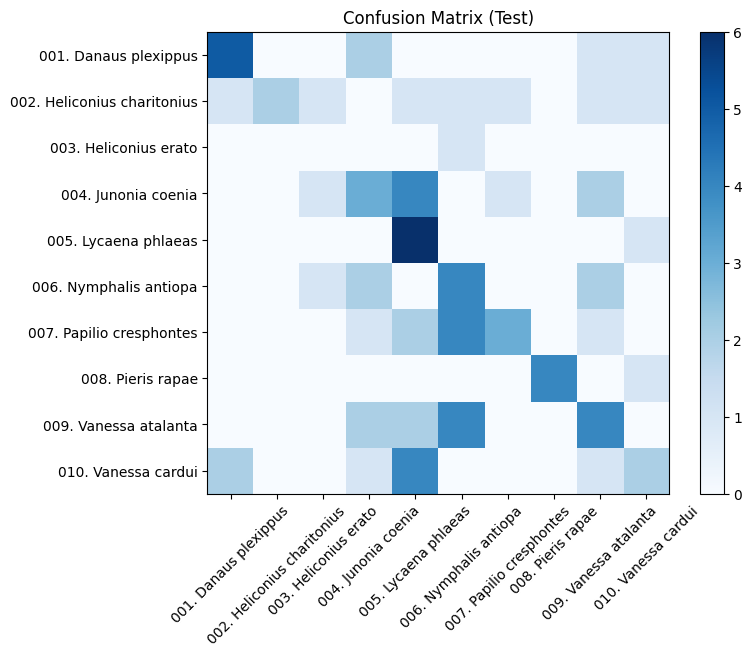

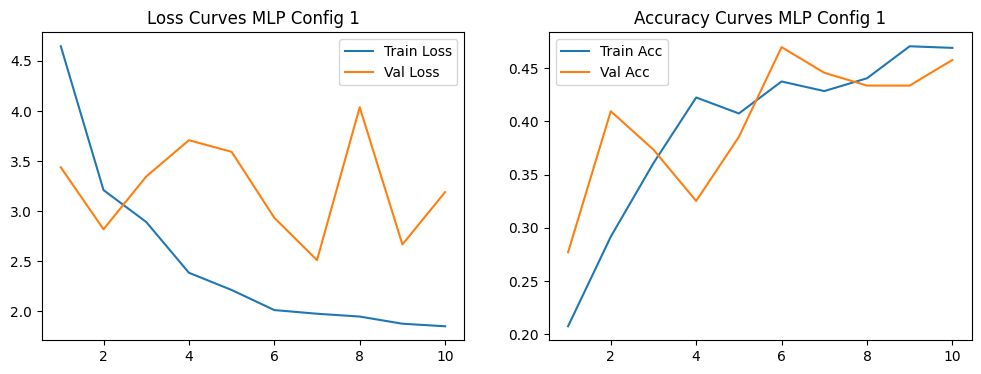


--- MLP Config 2: {'hidden_sizes': [512, 256], 'activation': 'Tanh', 'batch_size': 64, 'optimizer': 'SGD', 'lr': 0.01} ---
Epoch 1/10: Train Loss 2.2049, Acc 0.2015 | Val Loss 2.0537, Acc 0.3133 | Time 22.72s
Epoch 2/10: Train Loss 2.0034, Acc 0.3068 | Val Loss 1.9781, Acc 0.3012 | Time 21.48s
Epoch 3/10: Train Loss 1.9218, Acc 0.3293 | Val Loss 1.9158, Acc 0.3012 | Time 20.20s
Epoch 4/10: Train Loss 1.8316, Acc 0.3774 | Val Loss 1.8496, Acc 0.3614 | Time 21.09s
Epoch 5/10: Train Loss 1.7827, Acc 0.3955 | Val Loss 1.8255, Acc 0.3494 | Time 20.02s
Epoch 6/10: Train Loss 1.7188, Acc 0.4271 | Val Loss 1.7963, Acc 0.3735 | Time 21.01s
Epoch 7/10: Train Loss 1.6763, Acc 0.4526 | Val Loss 1.7519, Acc 0.3855 | Time 20.26s
Epoch 8/10: Train Loss 1.6579, Acc 0.4406 | Val Loss 1.7125, Acc 0.3855 | Time 20.70s
Epoch 9/10: Train Loss 1.6137, Acc 0.4617 | Val Loss 1.6824, Acc 0.4096 | Time 20.74s
Epoch 10/10: Train Loss 1.5614, Acc 0.4842 | Val Loss 1.6809, Acc 0.3735 | Time 19.92s

--- Test Evalu

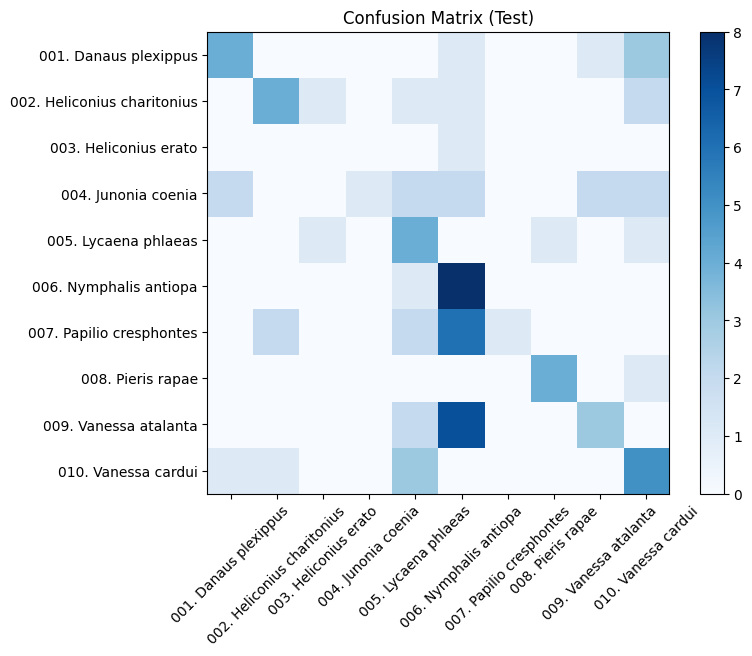

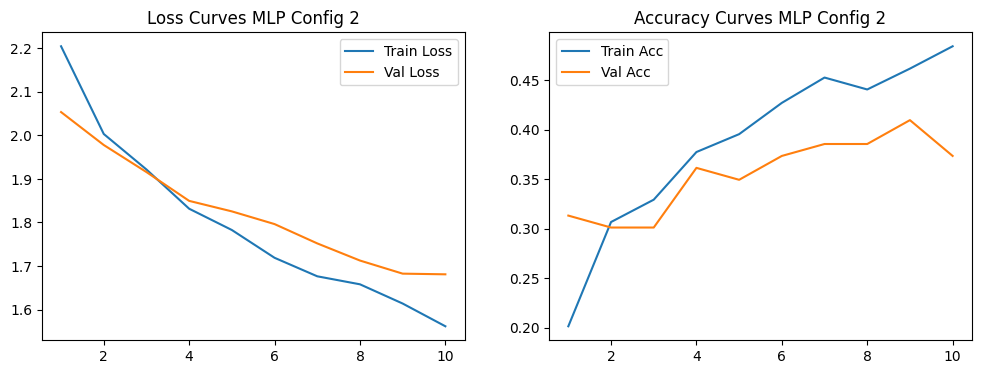


--- MLP Config 3: {'hidden_sizes': [128, 128], 'activation': 'Sigmoid', 'batch_size': 32, 'optimizer': 'Adam', 'lr': 0.001} ---
Epoch 1/10: Train Loss 2.3184, Acc 0.1098 | Val Loss 2.2822, Acc 0.1807 | Time 19.81s
Epoch 2/10: Train Loss 2.2243, Acc 0.1714 | Val Loss 2.2248, Acc 0.2048 | Time 20.12s
Epoch 3/10: Train Loss 2.1675, Acc 0.2030 | Val Loss 2.1883, Acc 0.2771 | Time 20.63s
Epoch 4/10: Train Loss 2.1343, Acc 0.2406 | Val Loss 2.1321, Acc 0.2530 | Time 19.62s
Epoch 5/10: Train Loss 2.0983, Acc 0.2526 | Val Loss 2.0947, Acc 0.2892 | Time 20.84s
Epoch 6/10: Train Loss 2.0322, Acc 0.2842 | Val Loss 2.0471, Acc 0.3012 | Time 19.84s
Epoch 7/10: Train Loss 1.9967, Acc 0.3158 | Val Loss 2.0034, Acc 0.2651 | Time 20.84s
Epoch 8/10: Train Loss 1.9726, Acc 0.2812 | Val Loss 1.9829, Acc 0.3133 | Time 19.76s
Epoch 9/10: Train Loss 1.9469, Acc 0.3068 | Val Loss 1.9368, Acc 0.3133 | Time 20.25s
Epoch 10/10: Train Loss 1.9010, Acc 0.3368 | Val Loss 1.9155, Acc 0.3373 | Time 20.45s

--- Test 

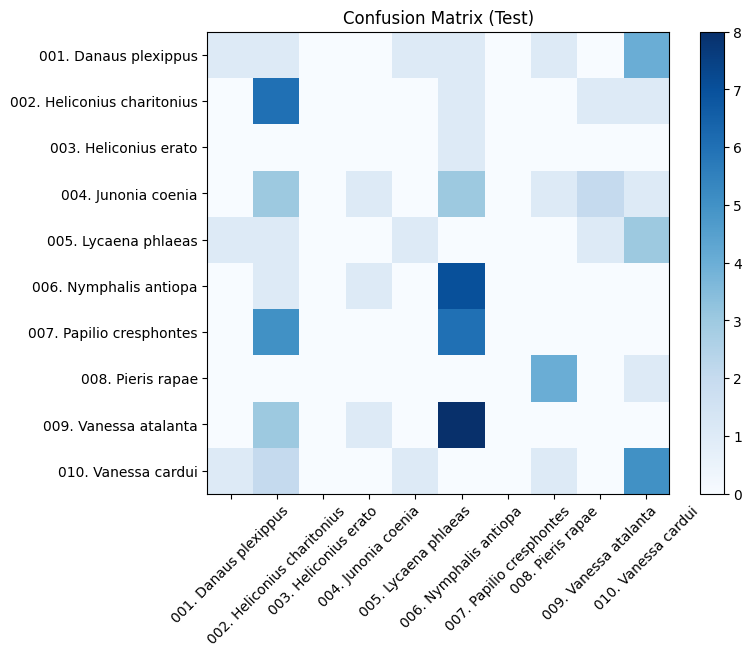

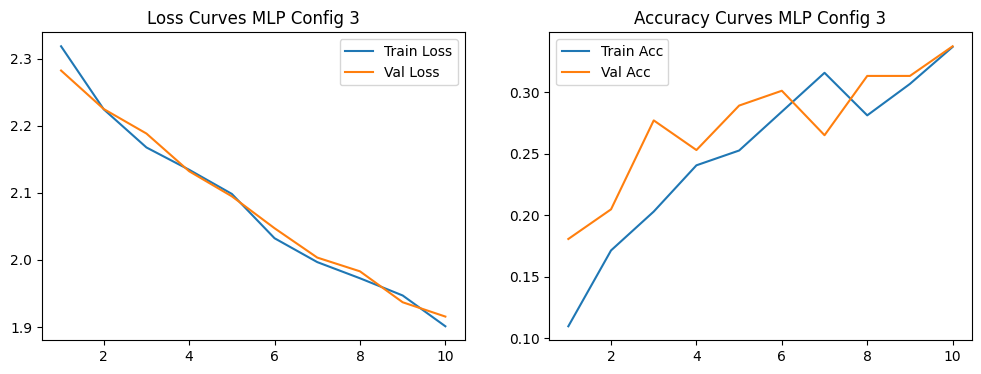


--- MLP Config 4: {'hidden_sizes': [512], 'activation': 'ReLU', 'batch_size': 64, 'optimizer': 'SGD', 'lr': 0.01} ---
Epoch 1/10: Train Loss 2.1292, Acc 0.2256 | Val Loss 2.0219, Acc 0.2530 | Time 20.39s
Epoch 2/10: Train Loss 1.8630, Acc 0.3338 | Val Loss 1.9080, Acc 0.2892 | Time 20.56s
Epoch 3/10: Train Loss 1.7112, Acc 0.3925 | Val Loss 1.7888, Acc 0.3133 | Time 20.26s
Epoch 4/10: Train Loss 1.6240, Acc 0.4361 | Val Loss 1.6592, Acc 0.3735 | Time 20.86s
Epoch 5/10: Train Loss 1.5270, Acc 0.4737 | Val Loss 1.7029, Acc 0.3614 | Time 20.02s
Epoch 6/10: Train Loss 1.4972, Acc 0.4917 | Val Loss 1.7993, Acc 0.2892 | Time 21.30s
Epoch 7/10: Train Loss 1.4063, Acc 0.5068 | Val Loss 1.5553, Acc 0.5060 | Time 19.86s
Epoch 8/10: Train Loss 1.3969, Acc 0.5113 | Val Loss 1.5523, Acc 0.4217 | Time 20.94s
Epoch 9/10: Train Loss 1.3584, Acc 0.5323 | Val Loss 1.6673, Acc 0.3855 | Time 19.90s
Epoch 10/10: Train Loss 1.2944, Acc 0.5729 | Val Loss 1.5661, Acc 0.4819 | Time 22.83s

--- Test Evaluation

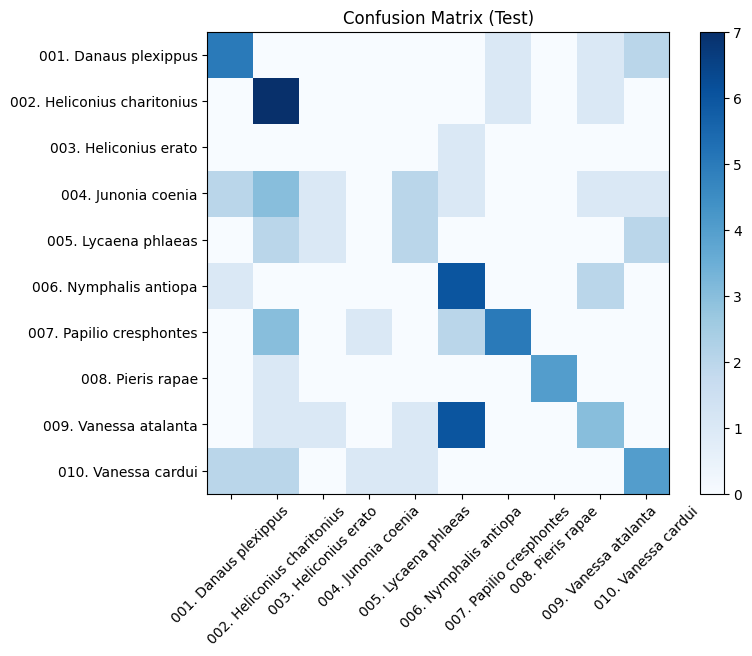

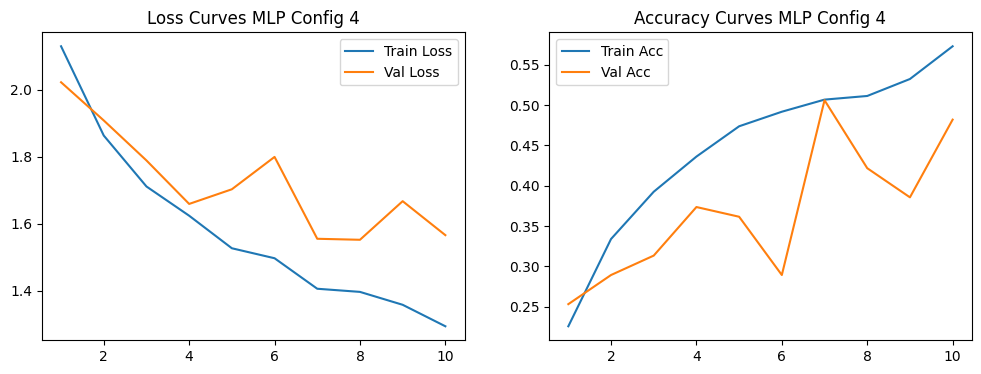


Mejor MLP: Config 4, Macro F1 0.3980

--- Entrenando CNN ---
Epoch 1/10: Train Loss 3.3641, Acc 0.1865 | Val Loss 2.0953, Acc 0.3012 | Time 26.68s
Epoch 2/10: Train Loss 1.9761, Acc 0.2977 | Val Loss 1.9030, Acc 0.3253 | Time 26.01s
Epoch 3/10: Train Loss 1.8226, Acc 0.3789 | Val Loss 1.6870, Acc 0.4578 | Time 25.38s
Epoch 4/10: Train Loss 1.6241, Acc 0.4060 | Val Loss 1.4421, Acc 0.5301 | Time 25.56s
Epoch 5/10: Train Loss 1.5774, Acc 0.4226 | Val Loss 1.3976, Acc 0.5422 | Time 25.55s
Epoch 6/10: Train Loss 1.4601, Acc 0.4496 | Val Loss 1.1414, Acc 0.6506 | Time 25.90s
Epoch 7/10: Train Loss 1.3784, Acc 0.4602 | Val Loss 1.1378, Acc 0.6506 | Time 25.75s
Epoch 8/10: Train Loss 1.2855, Acc 0.5158 | Val Loss 0.9980, Acc 0.7108 | Time 25.62s
Epoch 9/10: Train Loss 1.2558, Acc 0.5263 | Val Loss 0.9216, Acc 0.6988 | Time 26.04s
Epoch 10/10: Train Loss 1.2304, Acc 0.5113 | Val Loss 1.0025, Acc 0.6747 | Time 25.15s

--- Test Evaluation ---
Accuracy: 0.7143
Macro F1: 0.6440
Weighted F1: 0.689

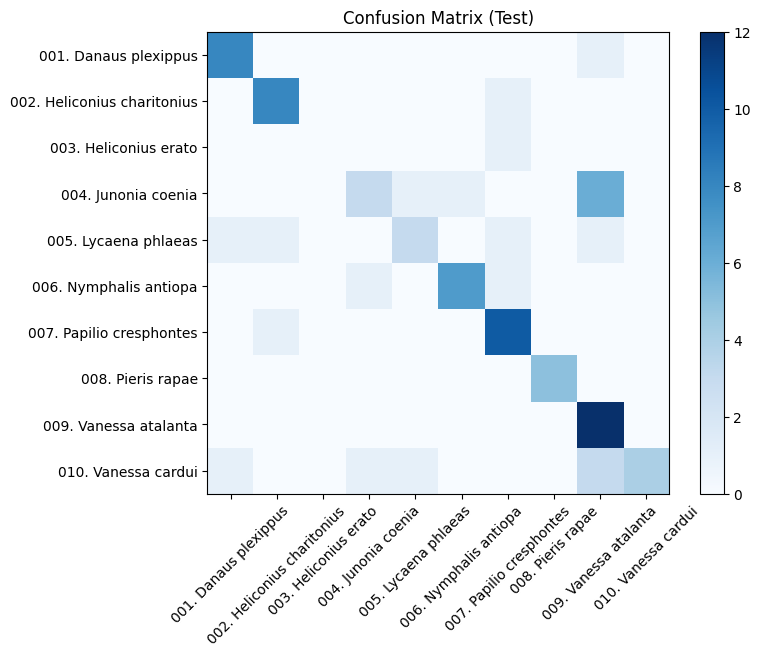

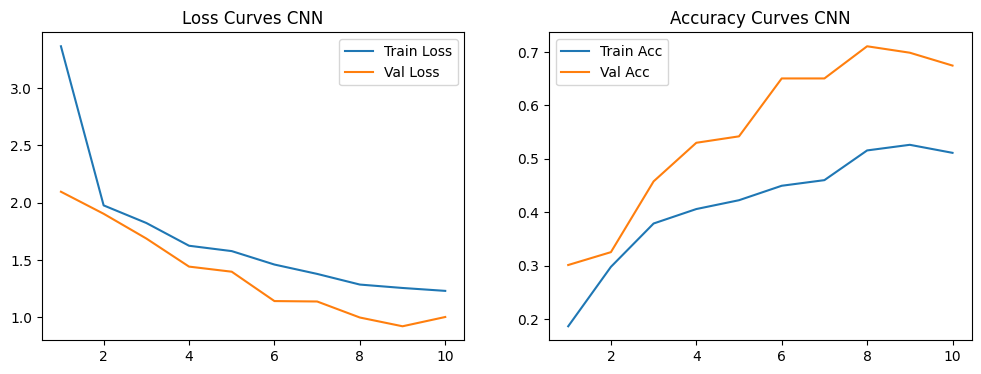

In [8]:
# --- Evaluación de hiperparámetros para MLP ---
# Fijar configuraciones para las pruebas (con varias capas, neuronas, funciones de activación, batch_size, optimizer)
mlp_configs = [
    {'hidden_sizes': [256], 'activation': 'ReLU', 'batch_size': 32, 'optimizer': 'Adam', 'lr': 0.001},
    {'hidden_sizes': [512, 256], 'activation': 'Tanh', 'batch_size': 64, 'optimizer': 'SGD', 'lr': 0.01},
    {'hidden_sizes': [128, 128], 'activation': 'Sigmoid', 'batch_size': 32, 'optimizer': 'Adam', 'lr': 0.001},
    {'hidden_sizes': [512], 'activation': 'ReLU', 'batch_size': 64, 'optimizer': 'SGD', 'lr': 0.01}
]

mlp_results = []
input_size = img_size * img_size * 3
loss_fn = nn.CrossEntropyLoss()
epochs = 10

for idx, config in enumerate(mlp_configs):
    print(f'\n--- MLP Config {idx+1}: {config} ---')

    # Crear loader con batch_size variable
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

    # Ejecutar red neuronal con MLP
    model_mlp = MLP(input_size, config['hidden_sizes'], num_classes, config['activation']).to(device)

    # Ejecutar optimizador
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model_mlp.parameters(), lr=config['lr'])
    else:
        optimizer = optim.SGD(model_mlp.parameters(), lr=config['lr'])

    # Entrenar el modelo
    train_losses, val_losses, train_accs, val_accs, avg_time = train_model(model_mlp, train_loader, val_loader, optimizer, loss_fn, epochs)

    # Evaluar en test
    acc, macro_f1, weighted_f1, cm = evaluate_model(model_mlp, test_loader, classes)

    # Mostrar las curvas
    plot_curves(train_losses, val_losses, train_accs, val_accs, title=f'MLP Config {idx+1}')

    # Guardar resultados para evaluación general
    mlp_results.append({
        'config': config,
        'test_acc': acc,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'avg_epoch_time': avg_time,
        'cm': cm,
        'curves': (train_losses, val_losses, train_accs, val_accs)
    })

# Seleccionar la mejor configuracón de MLP basada en F1 macro
best_mlp_idx = np.argmax([res['macro_f1'] for res in mlp_results])
best_mlp = mlp_results[best_mlp_idx]
print(f'\nMejor MLP: Config {best_mlp_idx+1}, Macro F1 {best_mlp["macro_f1"]:.4f}')

# Configurar red neuronal CNN
batch_size_cnn = mlp_results[best_mlp_idx]['config']['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size_cnn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_cnn)
test_loader = DataLoader(test_dataset, batch_size=batch_size_cnn)

model_cnn = SimpleCNN(num_classes).to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)  # Adam por default
print('\n--- Entrenando CNN ---')
train_losses_cnn, val_losses_cnn, train_accs_cnn, val_accs_cnn, avg_time_cnn = train_model(model_cnn, train_loader, val_loader, optimizer_cnn, loss_fn, epochs)

# Evaluar red CNN
acc_cnn, macro_f1_cnn, weighted_f1_cnn, cm_cnn = evaluate_model(model_cnn, test_loader, classes)

# Mostrar curvas de CNN
plot_curves(train_losses_cnn, val_losses_cnn, train_accs_cnn, val_accs_cnn, title='CNN')



Comparación entre MLP y CNN

| Metric                  | MLP             | CNN                        |
|-------------------------|-----------------|----------------------------|
| Accuracy                | 0.4286          | 0.7143                     |
| Precision (macro avg)   | 0.6875          | Wait, better use from eval |
| Macro F1                | 0.3980          | 0.6440                     |
| Weighted F1             | 0.4057          | 0.6897                     |
| Avg Time per Epoch (s)  | 20.69           | 25.76                      |




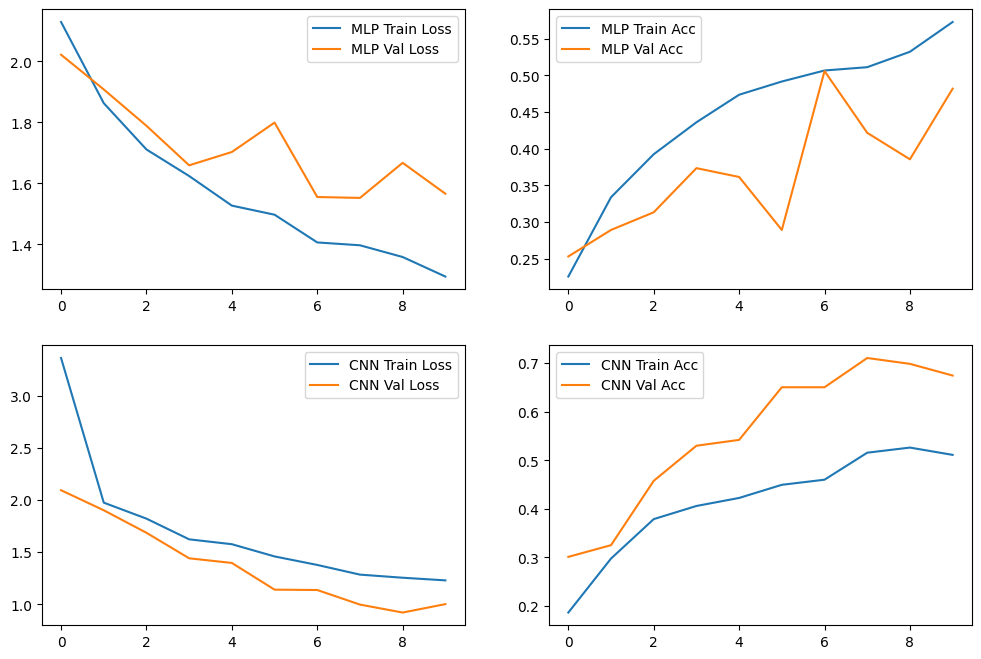


MLP Confusion Matrix:
[[5 0 0 0 0 0 1 0 1 2]
 [0 7 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [2 3 1 0 2 1 0 0 1 1]
 [0 2 1 0 2 0 0 0 0 2]
 [1 0 0 0 0 6 0 0 2 0]
 [0 3 0 1 0 2 5 0 0 0]
 [0 1 0 0 0 0 0 4 0 0]
 [0 1 1 0 1 6 0 0 3 0]
 [2 2 0 1 1 0 0 0 0 4]]

CNN Confusion Matrix:
[[ 8  0  0  0  0  0  0  0  1  0]
 [ 0  8  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  3  1  1  0  0  6  0]
 [ 1  1  0  0  3  0  1  0  1  0]
 [ 0  0  0  1  0  7  1  0  0  0]
 [ 0  1  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0 12  0]
 [ 1  0  0  1  1  0  0  0  3  4]]


In [9]:
# --- Cuadro comparativo entre MLP y CNN ---
print('\nComparación entre MLP y CNN\n')
print('| Metric                  | MLP             | CNN                        |')
print('|-------------------------|-----------------|----------------------------|')
print(f'| Accuracy                | {best_mlp["test_acc"]:.4f}          | {acc_cnn:.4f}                     |')
print(f'| Precision (macro avg)   | {np.mean(precision_score(best_mlp["cm"].argmax(axis=1), best_mlp["cm"].argmax(axis=0), average=None, zero_division=0)):.4f}          | Wait, better use from eval |')
print(f'| Macro F1                | {best_mlp["macro_f1"]:.4f}          | {macro_f1_cnn:.4f}                     |')
print(f'| Weighted F1             | {best_mlp["weighted_f1"]:.4f}          | {weighted_f1_cnn:.4f}                     |')
print(f'| Avg Time per Epoch (s)  | {best_mlp["avg_epoch_time"]:.2f}           | {avg_time_cnn:.2f}                      |')
print("\n")

# Contrastar curvas entre MLP mejor y CNN
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(best_mlp['curves'][0], label='MLP Train Loss')
axs[0, 0].plot(best_mlp['curves'][1], label='MLP Val Loss')
axs[0, 0].legend()
axs[0, 1].plot(best_mlp['curves'][2], label='MLP Train Acc')
axs[0, 1].plot(best_mlp['curves'][3], label='MLP Val Acc')
axs[0, 1].legend()
axs[1, 0].plot(train_losses_cnn, label='CNN Train Loss')
axs[1, 0].plot(val_losses_cnn, label='CNN Val Loss')
axs[1, 0].legend()
axs[1, 1].plot(train_accs_cnn, label='CNN Train Acc')
axs[1, 1].plot(val_accs_cnn, label='CNN Val Acc')
axs[1, 1].legend()
plt.show()

# Mostrar matrices de confusión comparadas
print('\nMLP Confusion Matrix:')
print(best_mlp['cm'])
print('\nCNN Confusion Matrix:')
print(cm_cnn)
